In [27]:
import requests
import zipfile
import io
import os
import yaml
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
warnings.filterwarnings('ignore')

def generate_data(yamlFile):
    '''
    generate data and return csv names
    '''
    
    url = "http://oasis.caiso.com/oasisapi/SingleZip"
    extract_directory = ""
    csv_list = []
    start_time = yamlFile["start_time"]
    end_time = yamlFile["end_time"]
    forecast_type = yamlFile["forecast_type"]
    market_run_id = yamlFile["market_run_id"]
    execution_type = yamlFile["execution_type"]
    csv_name = f"{start_time}_{end_time}_{forecast_type}_{market_run_id}_{execution_type}.csv"
    csv_name = os.path.join("data", csv_name)
    start_time = datetime.strptime(start_time, "%Y%m%dT%H:%M%z")
    end_time = datetime.strptime(end_time, "%Y%m%dT%H:%M%z")
    merged_data = pd.DataFrame()

    if  not os.path.exists(csv_name):
        while end_time > start_time:
            def request(start_time, end_time):
                params = {
                    "resultformat": "6",
                    "queryname": forecast_type,
                    "market_run_id": market_run_id,
                    "execution_type": execution_type,
                    "version": "1",
                    "startdatetime": start_time.strftime('%Y%m%dT%H:%M%z').replace("+","-"),
                    "enddatetime": min(start_time + timedelta(days=30), end_time).strftime('%Y%m%dT%H:%M%z').replace("+","-")
                }

                response = requests.get(url, params=params)
                while response.status_code == 429:
                    time.sleep(1)
                    response = request(start_time, end_time)
                return response

            response=request(start_time, end_time)
            if response.status_code == 200:
                data = response.content
                zip_data = io.BytesIO(data)
                csv = None
                with zipfile.ZipFile(zip_data, 'r') as zip_ref:
                    file_bytes = zip_ref.read(zip_ref.namelist()[0])
                    merged_data = pd.concat([merged_data, pd.read_csv(io.BytesIO(file_bytes))], ignore_index=True)
            else:
                print("Request failed with status code:", response.status_code)
            
            start_time += timedelta(days=30)
            time.sleep(1)
            
        merged_data.to_csv(csv_name, index=False)
    return csv_name

In [28]:
def split_data(csv, yamlFile):
  '''
  split data from one csv to specific dataset
  '''
  
  data = pd.read_csv(csv)

  # print(data.shape)

  zone_id = yamlFile["zone_id"]
  training_set_start = yamlFile["training_set_start"]
  training_set_end = yamlFile["training_set_end"]
  validation_set_start = yamlFile["validation_set_start"]
  validation_set_end = yamlFile["validation_set_end"]
  test_set_start = yamlFile["test_set_start"]
  test_set_end = yamlFile["test_set_end"]
  TAC_AREA_NAME = yamlFile["TAC_AREA_NAME"]
  training_set = data.query(f'OPR_DT <= "{training_set_end}" and OPR_DT >= "{training_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  validation_set = data.query(f'OPR_DT <= "{validation_set_end}" and OPR_DT >= "{validation_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  test_set = data.query(f'OPR_DT <= "{test_set_end}" and OPR_DT >= "{test_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  training_set.loc[:, 'training_type'] = 'training'
  validation_set.loc[:, 'training_type'] = 'validation'
  test_set.loc[:, 'training_type'] = 'test'
  
  return training_set, validation_set, test_set

In [29]:
def limit_display(num_ticks):
  """
  limit display number of x data points
  """
  ax = plt.gca()
  x_ticks = ax.get_xticks()
  x_labels = ax.get_xticklabels()
  step = len(x_ticks) // num_ticks
  ax.set_xticks(x_ticks[::step])
  ax.set_xticklabels(x_labels[::step])
  plt.show()
  


In [30]:
  
def visualization(yamlFile):
  ''' 
  visualize for certain data, generate one graph
  '''
  csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  wholedata = pd.concat([training_set, validation_set])
  wholedata = wholedata.sort_values(by="INTERVALSTARTTIME_GMT")
  plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW", hue="training_type", kind="line", height=4, aspect=4)
  label = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
  plot.fig.suptitle(label)
  limit_display(5)
  # os.remove(csv)

In [31]:
def visualize_data():
  warnings.filterwarnings('ignore')
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)

  visualize_id = yamlFile['visualize_id']
  for run_id in visualize_id:
    if not visualize_id[run_id]:
      yamlFile['market_run_id'] = run_id
      yamlFile['execution_type'] = None
      with open('demand.yaml', 'w') as conf:
        yaml.dump(yamlFile, conf)
      visualization(yamlFile)

    else:
      for exec_type in visualize_id[run_id]:
        yamlFile['market_run_id'] = run_id
        yamlFile['execution_type'] = exec_type
        with open('demand.yaml', 'w') as conf:
          yaml.dump(yamlFile, conf)
        visualization(yamlFile)

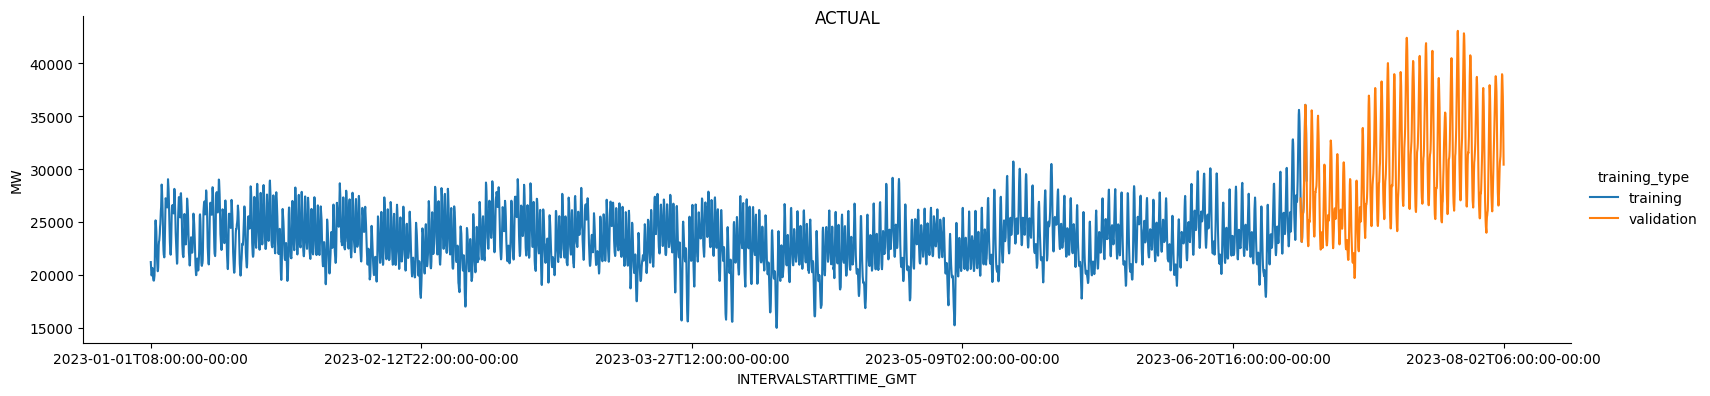

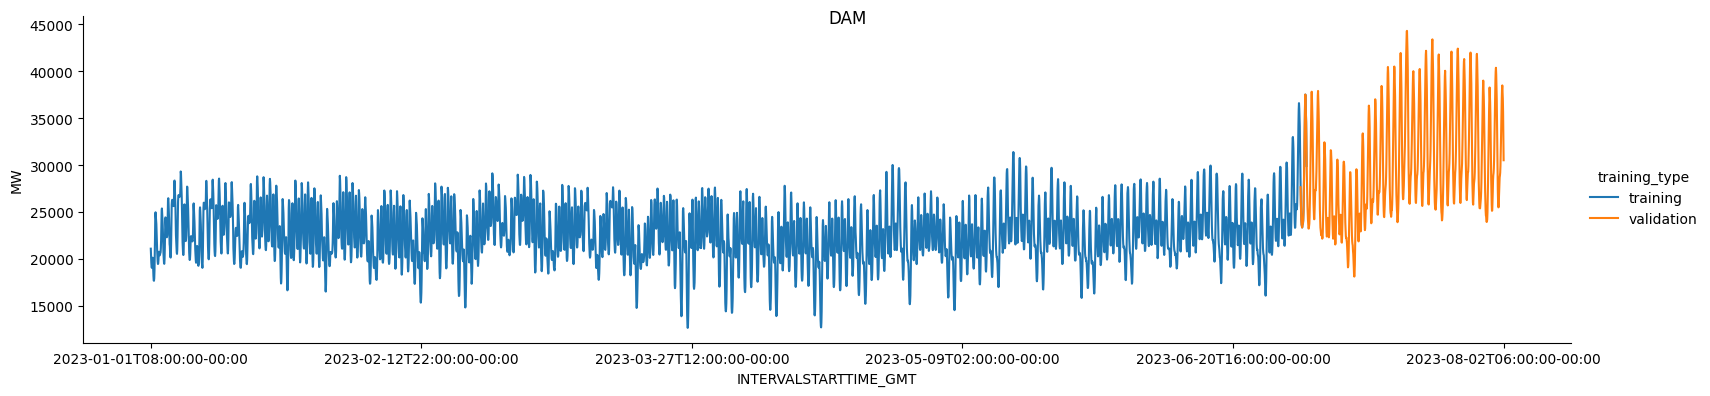

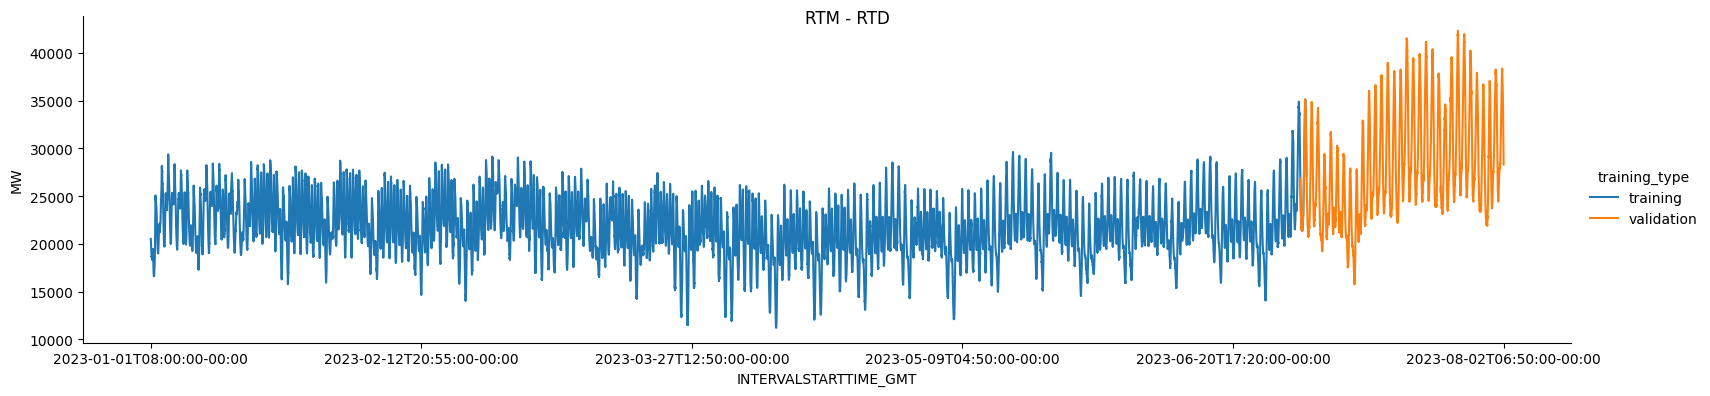

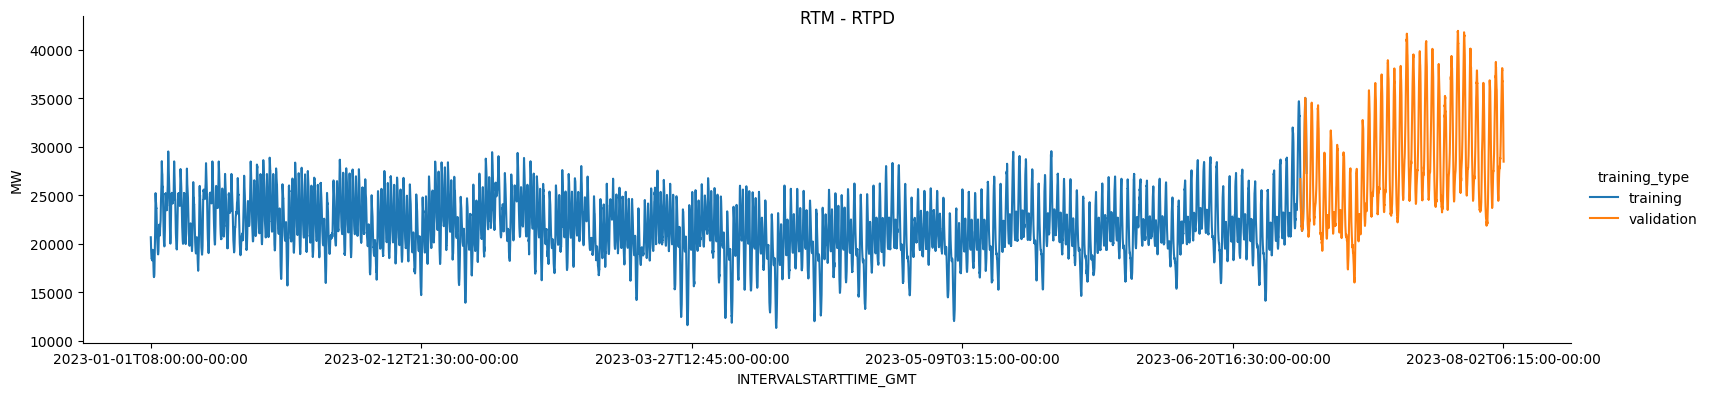

In [32]:
visualize_data()

In [33]:
def visulize_difference():
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)

  minus_visualize_id = yamlFile['minus_visualize']
  for minus_list in minus_visualize_id:
    yamlFile['market_run_id'] = minus_list[0]
    yamlFile['execution_type'] = minus_list[1]
    with open('demand.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set, test_set = split_data(csv, yamlFile)
    wholedata1 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label1 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    yamlFile['market_run_id'] = minus_list[2]
    yamlFile['execution_type'] = minus_list[3]
    with open('demand.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set, test_set = split_data(csv, yamlFile)
    wholedata2 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label2 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    wholedata = pd.merge(wholedata1, wholedata2, on='INTERVALSTARTTIME_GMT', suffixes=('_1', '_2'))
    wholedata['MW_diff'] = wholedata['MW_1'] - wholedata['MW_2']
    plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW_diff", hue="training_type_1", kind="line", height=4, aspect=4)
    plot.fig.suptitle(label1+" minus "+label2)
    limit_display(5)

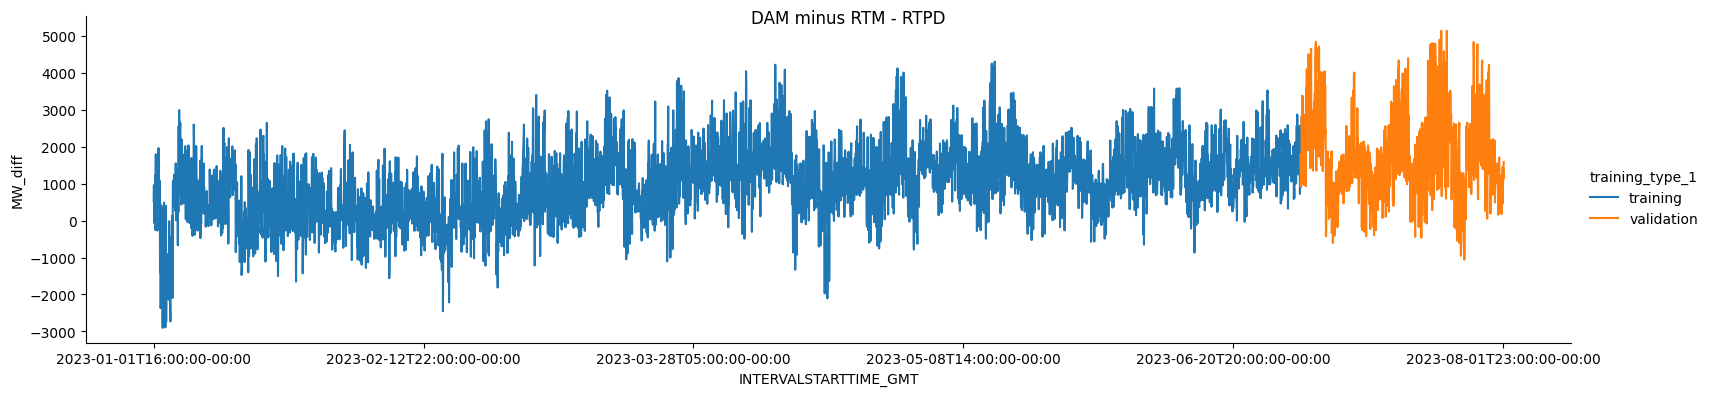

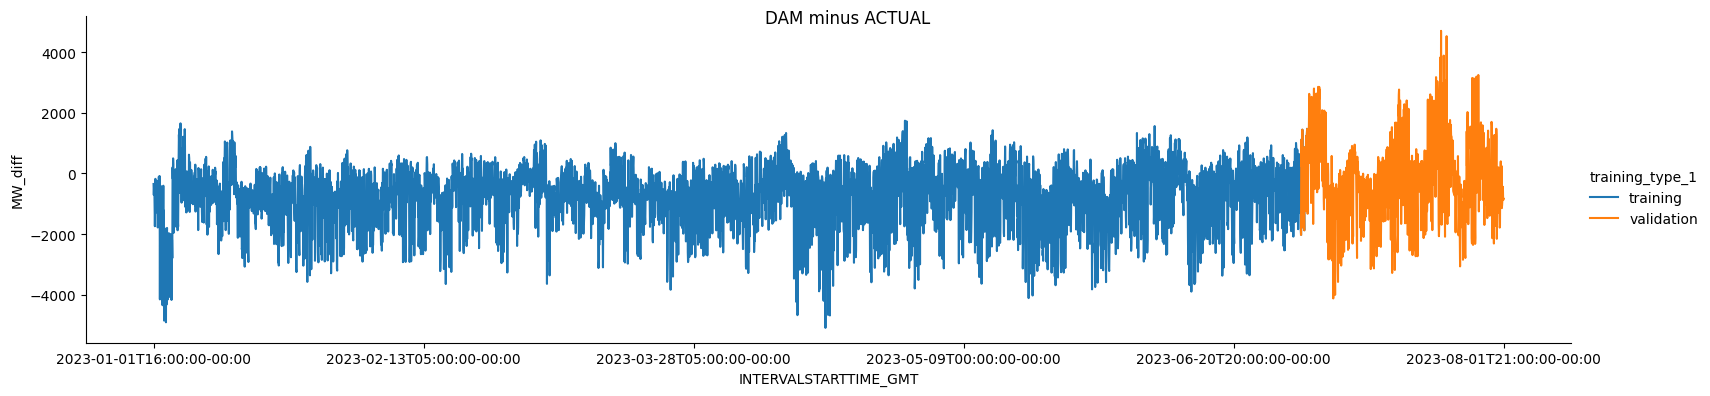

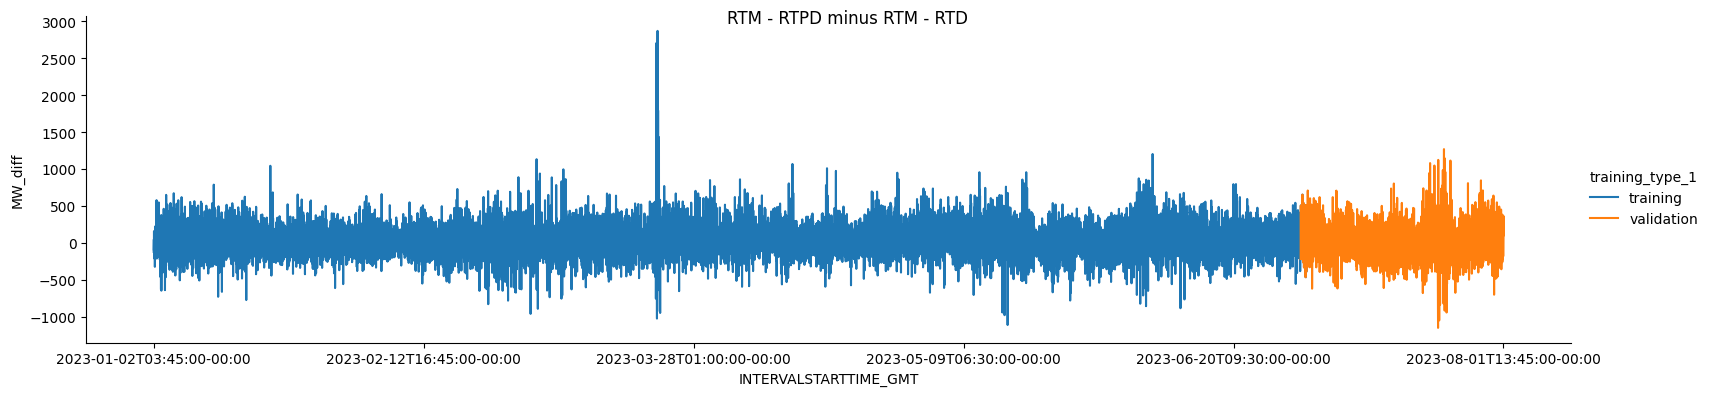

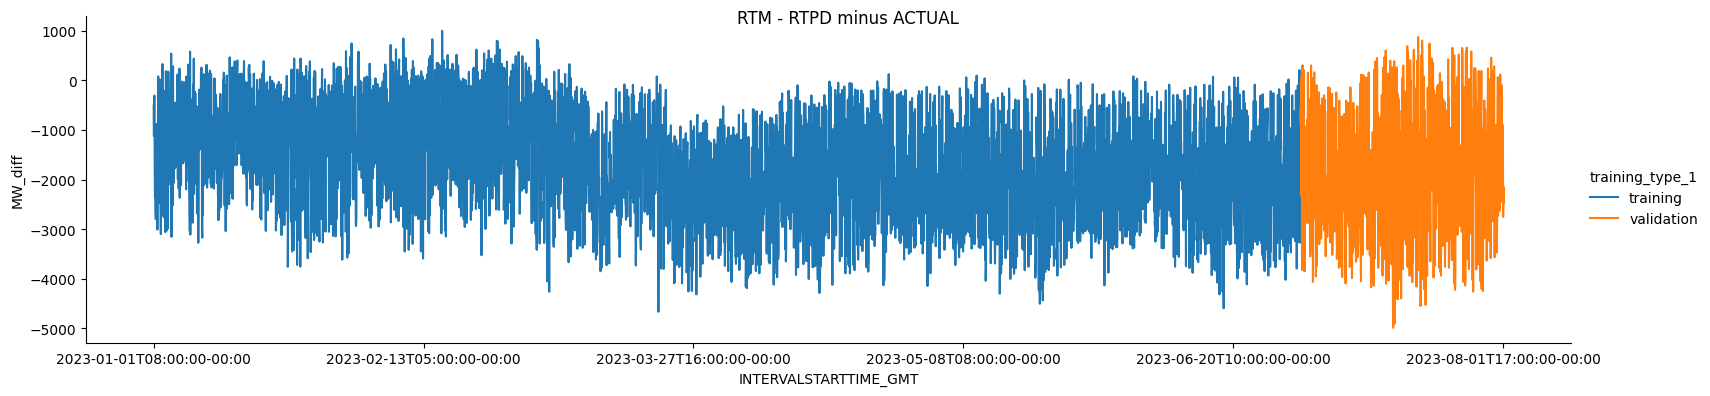

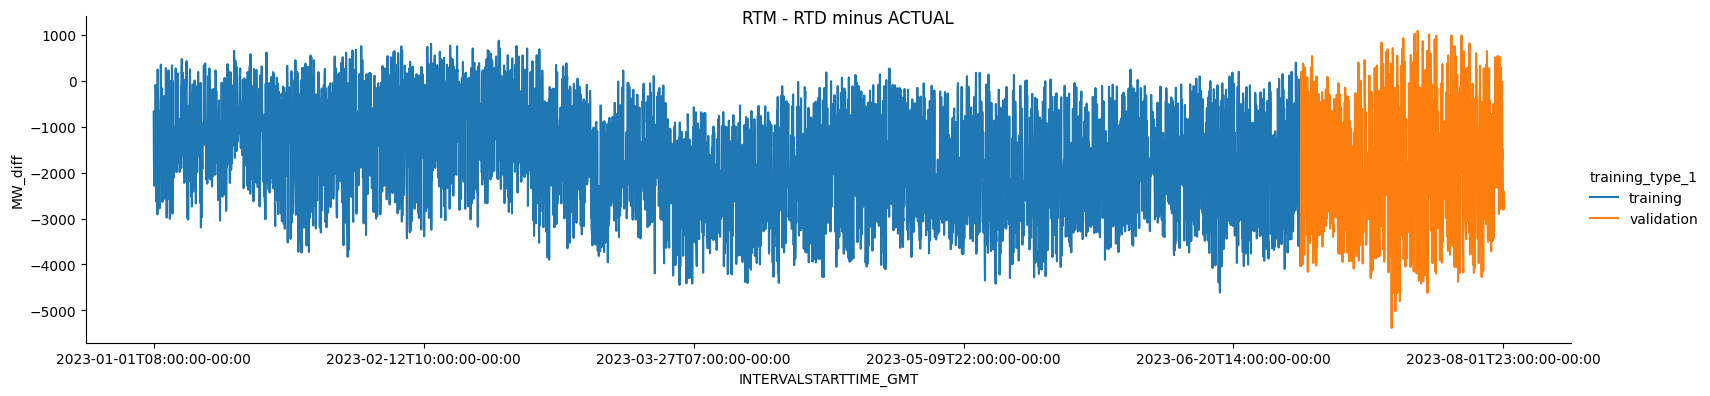

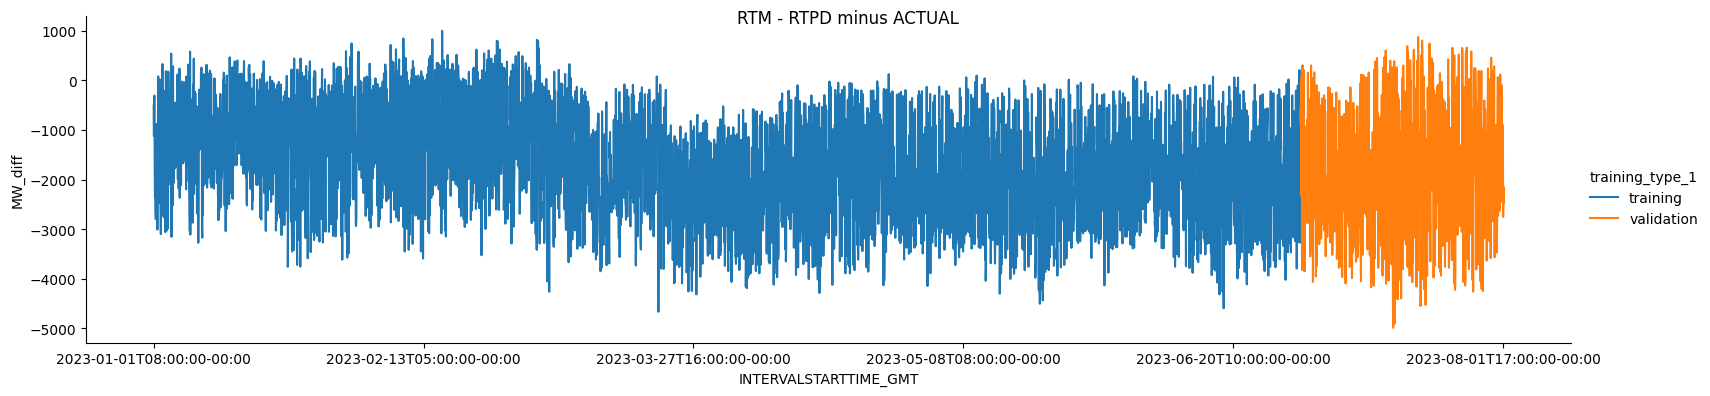

In [34]:
visulize_difference()

In [35]:
def CAISO_forecast():
  ''' 
  get the CAISO forecast data as training set, e.g. DAM
  '''
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)
  with open('demand.yaml', 'w') as conf:
    yamlFile['market_run_id'] = "DAM"
    yamlFile['execution_type'] = None
    yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  return np.array(training_set["INTERVALSTARTTIME_GMT"]), np.array(training_set["MW"]), np.array(validation_set["INTERVALSTARTTIME_GMT"]), np.array(validation_set["MW"]), np.array(test_set["INTERVALSTARTTIME_GMT"]), np.array(test_set["MW"])
  
def GodMode():
  ''' 
  get the actual data
  '''
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)
  with open('demand.yaml', 'w') as conf:
    yamlFile['market_run_id'] = "ACTUAL"
    yamlFile['execution_type'] = None
    yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  return np.array(training_set["INTERVALSTARTTIME_GMT"]), np.array(training_set["MW"]), np.array(validation_set["INTERVALSTARTTIME_GMT"]), np.array(validation_set["MW"]), np.array(test_set["INTERVALSTARTTIME_GMT"]), np.array(test_set["MW"])
  
def add_gaussian_noise(y, k):
  std = k * np.max(y)
  noise = np.random.normal(loc=0, scale=std, size=y.shape)
  noise = noise - np.mean(noise)
  y_noisy = y + noise
  return y_noisy

def add_beta_noise(y, k):
    std = k * np.max(y)
    alpha, beta = 1, 1
    noise = np.random.beta(alpha, beta, size=y.shape)
    ratio = std/np.std(noise)
    noise = noise*ratio
    noise = noise - np.mean(noise)
    y_noisy = y + noise
    return y_noisy
  
def add_weibull_noise(y, k):
  std = k * np.max(y)
  noise = np.random.weibull(2, size=y.shape)
  ratio = std/np.std(noise)
  noise = noise*ratio
  noise = noise - np.mean(noise)
  y_noisy = y + noise

  return y_noisy
      
def add_laplace_noise(y, k):
    std = k * np.max(y)
    noise = np.random.laplace(scale=std, size=y.shape)
    ratio = std/np.std(noise)
    noise = noise*ratio
    noise = noise - np.mean(noise)
    y_noisy = y + noise

    return y_noisy

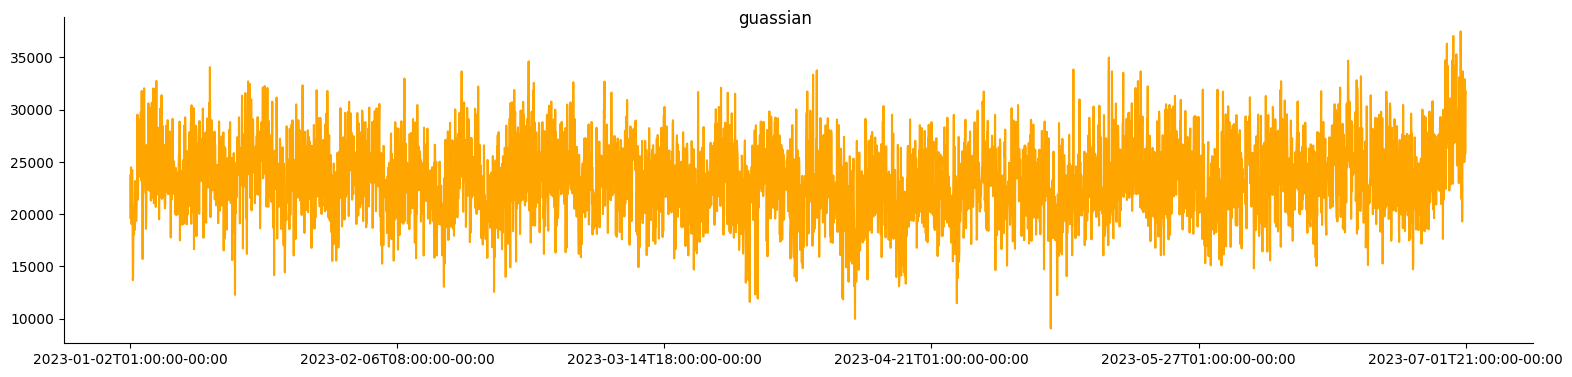

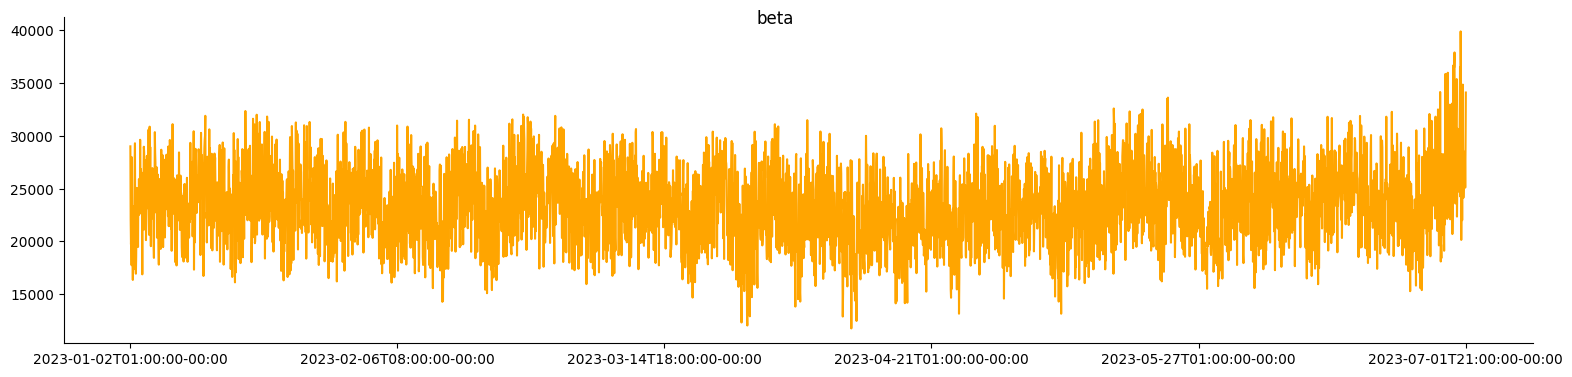

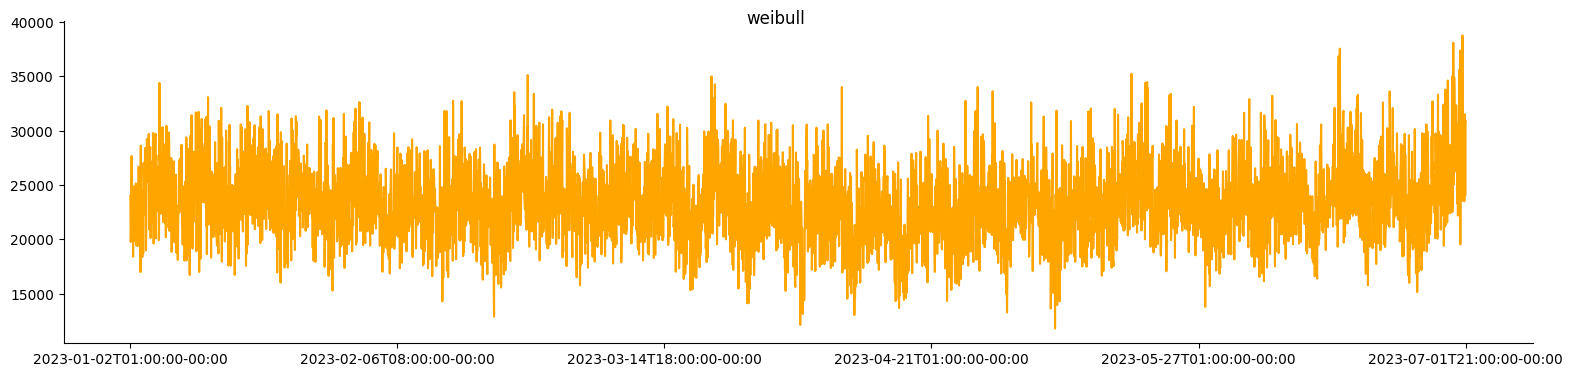

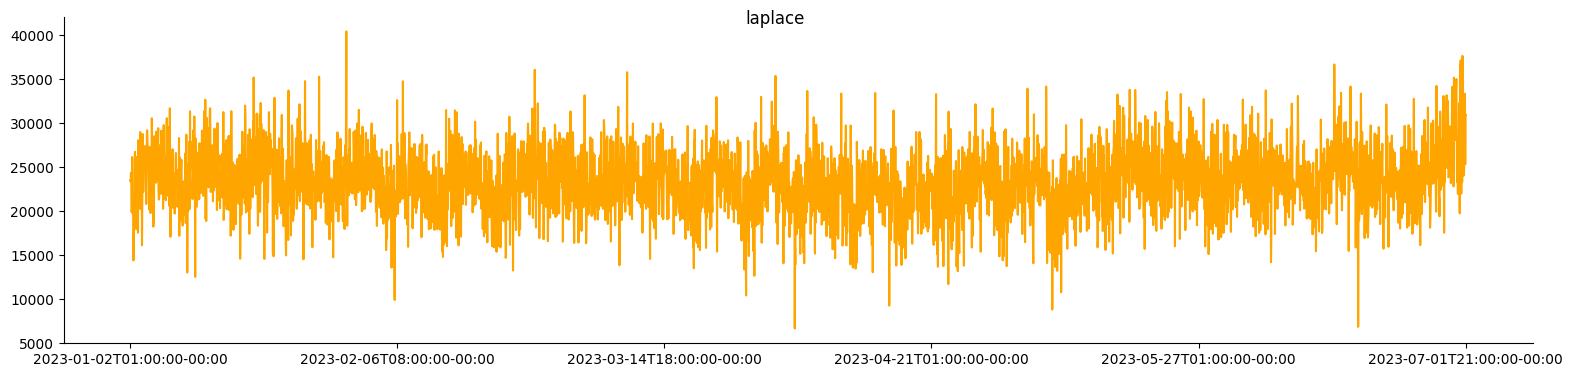

In [36]:
warnings.filterwarnings('ignore')

time_arr, y_DAM, time_arr_val, y_DAM_val, time_arr_test, y_DAM_test = CAISO_forecast()
time_arr, y_truth, time_arr_val, y_truth_val, time_arr_test, y_truth_test = GodMode()


error_range_rate = 0.07
y_guassian = add_gaussian_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_guassian, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("guassian")
limit_display(5)

y_beta = add_beta_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_beta, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("beta")
limit_display(5)

y_weibull = add_weibull_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_weibull, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("weibull")
limit_display(5)

y_laplace = add_laplace_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_laplace, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("laplace")
limit_display(5)


In [37]:
warnings.filterwarnings('ignore')

error_range_rate = 0.07
time_arr, y_DAM, time_arr_val, y_DAM_val, time_arr_test, y_DAM_test = CAISO_forecast()
time_arr, y_truth, time_arr_val, y_truth_val, time_arr_test, y_truth_test = GodMode()
y_guassian = add_gaussian_noise(y_truth, error_range_rate)
y_beta = add_beta_noise(y_truth, error_range_rate)
y_weibull = add_weibull_noise(y_truth, error_range_rate)
y_laplace = add_laplace_noise(y_truth, error_range_rate)

y_guassian_val = add_gaussian_noise(y_truth_val, error_range_rate)
y_beta_val = add_beta_noise(y_truth_val, error_range_rate)
y_weibull_val = add_weibull_noise(y_truth_val, error_range_rate)
y_laplace_val = add_laplace_noise(y_truth_val, error_range_rate)

y_guassian_test = add_gaussian_noise(y_truth_test, error_range_rate)
y_beta_test = add_beta_noise(y_truth_test, error_range_rate)
y_weibull_test = add_weibull_noise(y_truth_test, error_range_rate)
y_laplace_test = add_laplace_noise(y_truth_test, error_range_rate)

X_train = np.concatenate([y_DAM.reshape(-1,1), y_guassian.reshape(-1,1), y_beta.reshape(-1,1), y_weibull.reshape(-1,1), y_laplace.reshape(-1,1), y_truth.reshape(-1,1)], axis=1)
X_val = np.concatenate([y_DAM_val.reshape(-1,1), y_guassian_val.reshape(-1,1), y_beta_val.reshape(-1,1), y_weibull_val.reshape(-1,1), y_laplace_val.reshape(-1,1), y_truth_val.reshape(-1,1)], axis=1)
X_test = np.concatenate([y_DAM_test.reshape(-1,1), y_guassian_test.reshape(-1,1), y_beta_test.reshape(-1,1), y_weibull_test.reshape(-1,1), y_laplace_test.reshape(-1,1), y_truth_test.reshape(-1,1)], axis=1)
N = len(time_arr)
N_val = len(time_arr_val)
N_test = len(time_arr_test)
Y_train = y_truth
Y_val = y_truth_val
Y_test = y_truth_test


In [38]:
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


def KNN(X_train, Y_train, X_val, Y_val, K):
  """
  K nearest neighbour algorithm
  """
  knn = KNeighborsRegressor(n_neighbors=K)
  knn.fit(X_train, Y_train)
  Y_pred = knn.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("KNN Model Parameters:", knn.get_params())
  return rmse, Y_pred



def MLP(X_train, Y_train, X_val, Y_val, epoch):
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(5,)))  
  model.add(Dense(64, activation='relu'))  
  model.add(Dense(1))  
  model.compile(optimizer='adam', loss='mse')
  model.fit(X_train, Y_train, epochs=epoch, batch_size=32, verbose=0)
  Y_pred = model.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("MLP Model Parameters:", model.get_config())
  return rmse, Y_pred


def LR(X_train, Y_train, X_val, Y_val):
  regression = LinearRegression()
  regression.fit(X_train, Y_train)
  Y_pred = regression.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("Intercept:", regression.intercept_)
  print("Coefficients:", regression.coef_)
  
  return rmse, Y_pred


def Forest(X_train, Y_train, X_val, Y_val, num):
  forest = RandomForestRegressor(n_estimators=num)
  forest.fit(X_train, Y_train)
  Y_pred = forest.predict(X_val)
  rmse = mean_squared_error(Y_val, Y_pred, squared=False)
  print("number of trees:", forest.n_estimators)
  print("max features:", forest.max_features)
  print("depth:", forest.max_depth)
  return rmse, Y_pred
  

In [39]:
print(X_train.shape)
print(Y_train.shape)

(4367, 6)
(4367,)


In [40]:
rmse_LR, Y_pred_LR = LR(X_train, Y_train, X_val, Y_val)
print(f"LR: {rmse_LR}")

Intercept: -7.275957614183426e-12
Coefficients: [-3.00690801e-16  5.55111512e-17  4.26980606e-17  1.73145057e-16
  3.29423518e-17  1.00000000e+00]
LR: 3.302793412861763e-12


In [41]:
X_train = X_train[:,:-1]
X_val = X_val[:,:-1]
X_test = X_test[:,:-1]

In [42]:
print(X_train.shape)
print(Y_train.shape)

(4367, 5)
(4367,)


In [43]:
DAM_rmse = np.sqrt(np.mean((X_val[:,0]-Y_val)**2))
print(f"baseline rmse: {DAM_rmse}")

baseline rmse: 6507.586144899136


KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
K=1, KNN: 2534.080456579204
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
K=2, KNN: 2365.591473094652
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
K=4, KNN: 2298.4545553164235
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
K=8, KNN: 2535.1938475359525
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
K=16, KNN: 2836.9206621158173


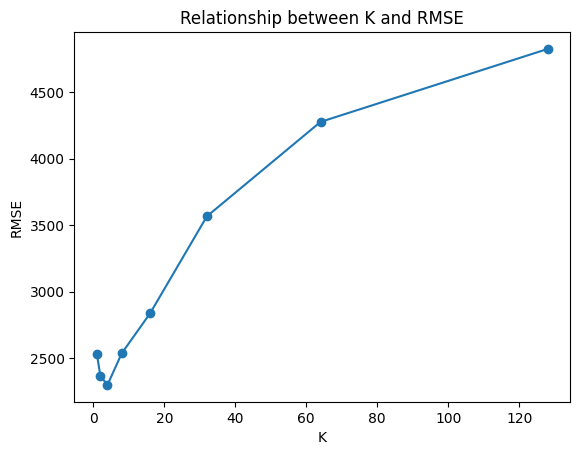

In [44]:
warnings.filterwarnings('ignore')
K_set = []
rmse_set = []
for K in [1, 2, 4, 8, 16, 32, 64, 128]:
  rmse_KNN, Y_pred_KNN = KNN(X_train, Y_train, X_val, Y_val, K)
  K_set.append(K)
  rmse_set.append(rmse_KNN)
  print(f"K={K}, KNN: {rmse_KNN}")
  
plt.plot(K_set, rmse_set, marker='o')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('Relationship between K and RMSE')
plt.show()

KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
K=1, KNN: 2534.080456579204
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
K=2, KNN: 2365.591473094652
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
K=3, KNN: 2286.5559064855156
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
K=4, KNN: 2298.4545553164235


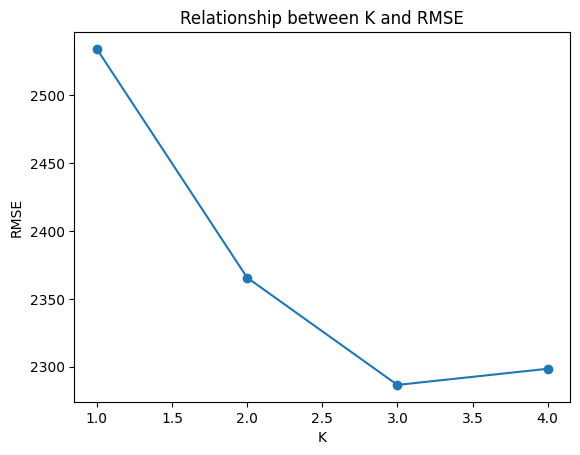

In [45]:
warnings.filterwarnings('ignore')
K_set = []
rmse_set = []
for K in range(1, 5):
  rmse_KNN, Y_pred_KNN = KNN(X_train, Y_train, X_val, Y_val, K)
  K_set.append(K)
  rmse_set.append(rmse_KNN)
  print(f"K={K}, KNN: {rmse_KNN}")
  
plt.plot(K_set, rmse_set, marker='o')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('Relationship between K and RMSE')
plt.show()

24/24 [==============================] - 0s 496us/step
MLP Model Parameters: {'name': 'sequential_11', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 5), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_33_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_33', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 5), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 5)}}, {'module': 'ker

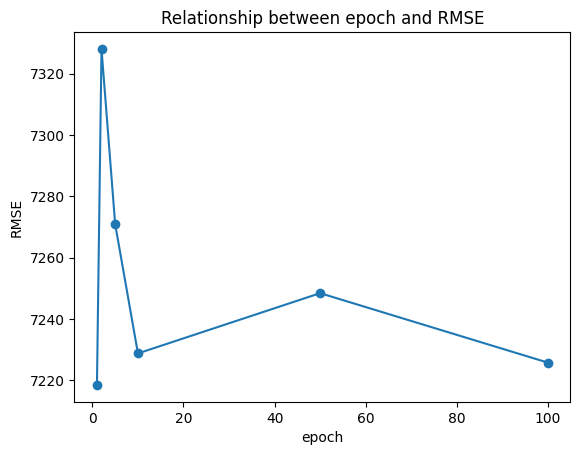

In [46]:
epoch_set = []
rmse_set = []
for epoch in [1, 2, 5, 10, 50, 100]:
  rmse_MLP, Y_pred_MLP = MLP(X_train, Y_train, X_val, Y_val, epoch)
  print(f"epoch:{epoch}, MLP: {rmse_MLP}")
  epoch_set.append(epoch)
  rmse_set.append(rmse_MLP)
  
plt.plot(epoch_set, rmse_set, marker='o')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Relationship between epoch and RMSE')
plt.show()

24/24 [==============================] - 0s 515us/step
MLP Model Parameters: {'name': 'sequential_17', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 5), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_51_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_51', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 5), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 5)}}, {'module': 'ker

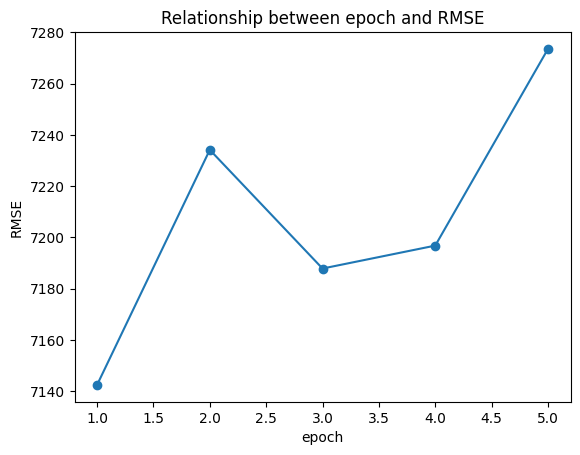

min_epoch=1, min_rmse=7142.429665176065


In [47]:
epoch_set = []
rmse_set = []
min_epoch, min_rmse = 0, 1e7
for epoch in range(1,6):
  rmse_MLP, Y_pred_MLP = MLP(X_train, Y_train, X_val, Y_val, epoch)
  print(f"epoch:{epoch}, MLP: {rmse_MLP}")
  epoch_set.append(epoch)
  rmse_set.append(rmse_MLP)
  if min_rmse>rmse_MLP:
    min_epoch, min_rmse = epoch, rmse_MLP
  
plt.plot(epoch_set, rmse_set, marker='o')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Relationship between epoch and RMSE')
plt.show()
print(f'min_epoch={min_epoch}, min_rmse={min_rmse}')

number of trees: 1
max features: 1.0
depth: None
n_estimators:1, rmse: 2405.8777685575765
number of trees: 2
max features: 1.0
depth: None
n_estimators:2, rmse: 2437.9754962226943
number of trees: 5
max features: 1.0
depth: None
n_estimators:5, rmse: 2296.694413524486
number of trees: 10
max features: 1.0
depth: None
n_estimators:10, rmse: 2359.3174114494964
number of trees: 50
max features: 1.0
depth: None
n_estimators:50, rmse: 2196.9783736360446
number of trees: 100
max features: 1.0
depth: None
n_estimators:100, rmse: 2178.5983786527427


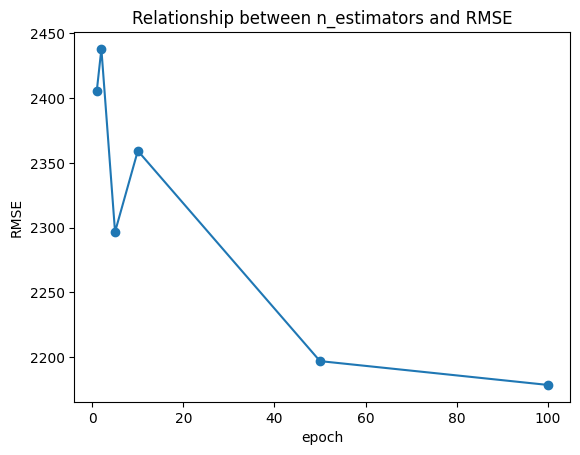

In [48]:
n_estimators_set = []
rmse_set = []
for n_estimators in [1, 2, 5, 10, 50, 100]:
  rmse_forest, Y_pred_forest = Forest(X_train, Y_train, X_val, Y_val, n_estimators)
  print(f"n_estimators:{n_estimators}, rmse: {rmse_forest}")
  n_estimators_set.append(n_estimators)
  rmse_set.append(rmse_forest)
  
plt.plot(n_estimators_set, rmse_set, marker='o')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Relationship between n_estimators and RMSE')
plt.show()

number of trees: 5
max features: 1.0
depth: None
number of trees: 6
max features: 1.0
depth: None
number of trees: 7
max features: 1.0
depth: None
number of trees: 8
max features: 1.0
depth: None
number of trees: 9
max features: 1.0
depth: None
number of trees: 10
max features: 1.0
depth: None
number of trees: 11
max features: 1.0
depth: None
number of trees: 12
max features: 1.0
depth: None
number of trees: 13
max features: 1.0
depth: None
number of trees: 14
max features: 1.0
depth: None
number of trees: 15
max features: 1.0
depth: None
number of trees: 16
max features: 1.0
depth: None
number of trees: 17
max features: 1.0
depth: None
number of trees: 18
max features: 1.0
depth: None
number of trees: 19
max features: 1.0
depth: None
number of trees: 20
max features: 1.0
depth: None
number of trees: 21
max features: 1.0
depth: None
number of trees: 22
max features: 1.0
depth: None
number of trees: 23
max features: 1.0
depth: None
number of trees: 24
max features: 1.0
depth: None
numbe

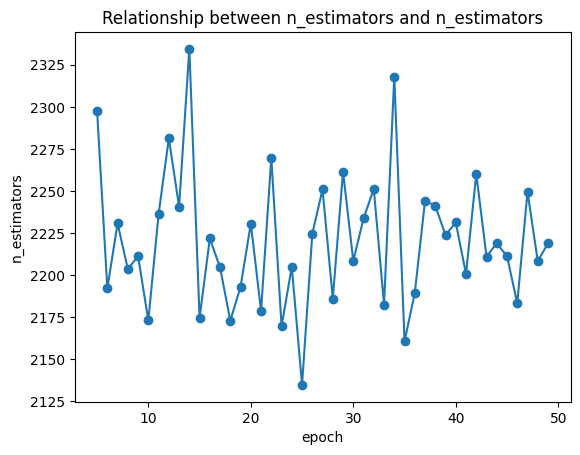

min_n_estimators=25, min_rmse=2134.770685414771


In [49]:
n_estimators_set = []
rmse_set = []
min_n_estimators, min_rmse = 0, 1e7
for n_estimators in range(5, 50):
  rmse_forest, Y_pred_forest = Forest(X_train, Y_train, X_val, Y_val, n_estimators)
  # print(f"n_estimators:{n_estimators}, rmse: {rmse_forest}")
  n_estimators_set.append(n_estimators)
  rmse_set.append(rmse_forest)
  if min_rmse>rmse_forest:
    min_n_estimators, min_rmse = n_estimators, rmse_forest
  
plt.plot(n_estimators_set, rmse_set, marker='o')
plt.xlabel('epoch')
plt.ylabel('n_estimators')
plt.title('Relationship between n_estimators and n_estimators')
plt.show()
print(f'min_n_estimators={min_n_estimators}, min_rmse={min_rmse}')

In [50]:
rmse_LR, Y_pred_LR = LR(X_train, Y_train, X_val, Y_val)
print(f"LR: {rmse_LR}")

Intercept: 3653.100787642332
Coefficients: [0.05216816 0.20140743 0.1926743  0.19898713 0.20032216]
LR: 1866.1905399951856


In [51]:
rmse_equal = np.sqrt(np.mean((np.average(X_val, axis=1)-Y_val)**2))
print(rmse_equal)

1785.898086015456


number of trees: 42
max features: 1.0
depth: None
-1088.0476190476184
2188.8666666666677
-6633.9000000000015


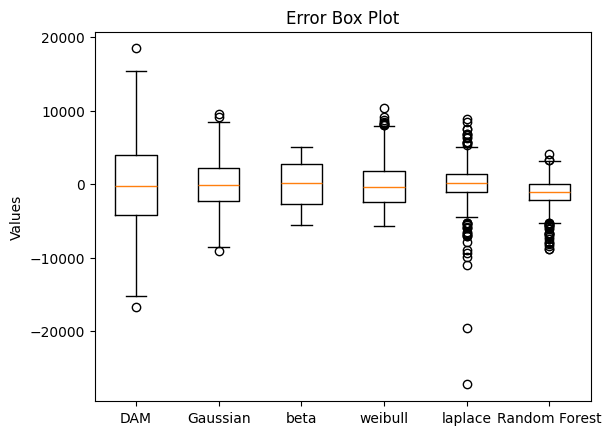

[6274.091745498951, 3247.990894389528, 3086.4400000000005, 3086.440000000001, 3086.4400000000005, 2355.3171381587927]


In [54]:
rmse_forest, Y_pred_forest = Forest(X_train, Y_train, X_test, Y_test, 42)
Error = Y_pred_forest - Y_test

# median, 97.5 percentile, 2.5 percentile
median = np.median(Error)
percentile_975 = np.percentile(Error, 97.5)
percentile_25 = np.percentile(Error, 2.5)
print(median)
print(percentile_975)
print(percentile_25)

# error box plot Error, F1,.. F5, ensemble
data = np.concatenate([X_test-Y_test[:,np.newaxis], Error.reshape((Error.shape[0],1))], axis=1)
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['DAM', 'Gaussian', 'beta', 'weibull', 'laplace', 'Random Forest'])
ax.set_ylabel('Values')
ax.set_title('Error Box Plot')
plt.show()


error = [
  np.sqrt(np.mean((X_test[:,0]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,1]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,2]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,3]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,4]-Y_test)**2)),\
  np.sqrt(np.mean((Error)**2))
  ]
print(error)

Intercept: 3653.100787642332
Coefficients: [0.05216816 0.20140743 0.1926743  0.19898713 0.20032216]
-1104.2010314859363
1841.9353651377862
-4351.936521913582


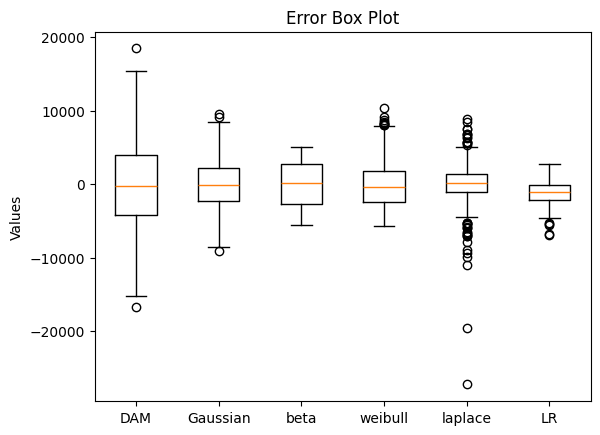

[6274.091745498951, 3247.990894389528, 3086.4400000000005, 3086.440000000001, 3086.4400000000005, 1897.9585760031575]


In [55]:
regression = LinearRegression()
regression.fit(X_train, Y_train)
Y_pred_test = regression.predict(X_test)
rmse = np.sqrt(np.mean((Y_pred_test-Y_test)**2))
print("Intercept:", regression.intercept_)
print("Coefficients:", regression.coef_)
Error = Y_pred_test - Y_test

# median, 97.5 percentile, 2.5 percentile
median = np.median(Error)
percentile_975 = np.percentile(Error, 97.5)
percentile_25 = np.percentile(Error, 2.5)
print(median)
print(percentile_975)
print(percentile_25)

# error box plot Error, F1,.. F5, ensemble
data = np.concatenate([X_test-Y_test[:,np.newaxis], Error.reshape((Error.shape[0],1))], axis=1)
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['DAM', 'Gaussian', 'beta', 'weibull', 'laplace', 'LR'])
ax.set_ylabel('Values')
ax.set_title('Error Box Plot')
plt.show()


error = [
  np.sqrt(np.mean((X_test[:,0]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,1]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,2]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,3]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,4]-Y_test)**2)),\
  np.sqrt(np.mean((Error)**2))
  ]
print(error)

In [63]:
def add_feedback(x, y):
  Previous = x[:-1]-y[:-1,np.newaxis]
  Error_array = x[1:] - Previous
  return np.concatenate([x[1:], Error_array],axis=1)

Intercept: 3654.5864735380746
Coefficients: [ 0.0537897   0.19762388  0.17811117  0.1976011   0.20770442 -0.00172574
  0.00359256  0.01445875  0.00166874 -0.00727782]
-1140.5515891660816
1844.637163218651
-4363.485277257958


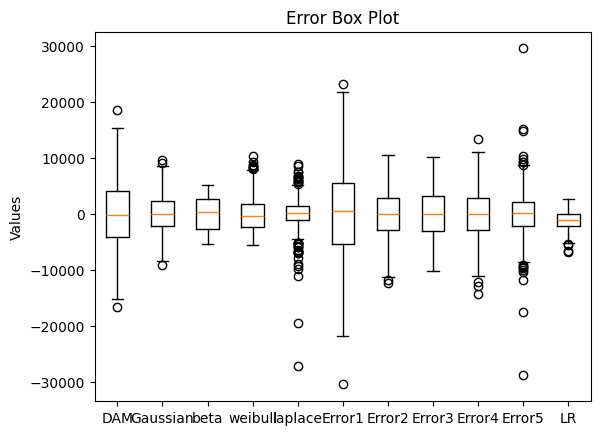

[6276.382259091069, 3251.5479410614503, 3079.4358193525754, 3066.5468783002693, 3089.8112146255557, 1899.9290207819215]


In [73]:
X_train_feedback = add_feedback(X_train, Y_train)
X_test_feedback = add_feedback(X_test, Y_test)
regression = LinearRegression()
regression.fit(X_train_feedback, Y_train[1:])
Y_pred_test = regression.predict(X_test_feedback)
rmse = np.sqrt(np.mean((Y_pred_test-Y_test[1:])**2))
print("Intercept:", regression.intercept_)
print("Coefficients:", regression.coef_)
Error = Y_pred_test - Y_test[1:]

# median, 97.5 percentile, 2.5 percentile
median = np.median(Error)
percentile_975 = np.percentile(Error, 97.5)
percentile_25 = np.percentile(Error, 2.5)
print(median)
print(percentile_975)
print(percentile_25)

# error box plot Error, F1,.. F5, ensemble
data = np.concatenate([X_test_feedback-Y_test[1:][:,np.newaxis], Error.reshape((Error.shape[0],1))], axis=1)
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['DAM', 'Gaussian', 'beta', 'weibull', 'laplace', 'Error1', 'Error2', 'Error3', 'Error4', 'Error5', 'LR'])
ax.set_ylabel('Values')
ax.set_title('Error Box Plot')
plt.show()


error = [
  np.sqrt(np.mean((X_test_feedback[:,0]-Y_test[1:])**2)),\
  np.sqrt(np.mean((X_test_feedback[:,1]-Y_test[1:])**2)),\
  np.sqrt(np.mean((X_test_feedback[:,2]-Y_test[1:])**2)),\
  np.sqrt(np.mean((X_test_feedback[:,3]-Y_test[1:])**2)),\
  np.sqrt(np.mean((X_test_feedback[:,4]-Y_test[1:])**2)),\
  np.sqrt(np.mean((Error)**2))
  ]
print(error)